In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

sample_submission.csv
test.csv
train.csv



In [2]:

import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score ,roc_curve,auc
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import time

from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV ,RandomizedSearchCV  #Perforing grid search
from sklearn.model_selection import StratifiedKFold
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4



/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:

train = pd.read_csv('../input/train.csv', na_values=-1)
test = pd.read_csv('../input/test.csv', na_values=-1)

In [47]:
train.dtypes

id                 int64
target             int64
ps_ind_01          uint8
ps_ind_02_cat      uint8
ps_ind_03          uint8
ps_ind_04_cat      uint8
ps_ind_05_cat      uint8
ps_ind_06_bin      uint8
ps_ind_07_bin      uint8
ps_ind_08_bin      uint8
ps_ind_09_bin      uint8
ps_ind_10_bin      uint8
ps_ind_11_bin      uint8
ps_ind_12_bin      uint8
ps_ind_13_bin      uint8
ps_ind_14          uint8
ps_ind_15          uint8
ps_ind_16_bin      uint8
ps_ind_17_bin      uint8
ps_ind_18_bin      uint8
ps_reg_01        float64
ps_reg_02        float64
ps_reg_03        float64
ps_car_01_cat      uint8
ps_car_02_cat      uint8
ps_car_03_cat      uint8
ps_car_04_cat      uint8
ps_car_05_cat      uint8
ps_car_06_cat      uint8
ps_car_07_cat      uint8
ps_car_08_cat      uint8
ps_car_09_cat      uint8
ps_car_10_cat      uint8
ps_car_11_cat      uint8
ps_car_11          uint8
ps_car_12        float64
ps_car_13        float64
ps_car_14        float64
ps_car_15        float64
dtype: object

In [5]:
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1.0,8,1.0,0.0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2.0,5,1.0,0.0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1.0,3,0.0,0.0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1.0,6,0.0,0.0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1.0,7,0.0,0.0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


In [7]:
#features = train.drop(['id','target'], axis=1).values
targets = train.target.values

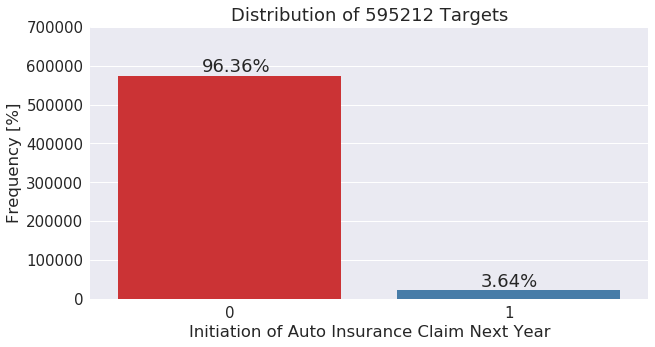

In [11]:
ax = sns.countplot(x = targets ,palette="Set1")
sns.set(font_scale=1.5)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
fig = plt.gcf()
fig.set_size_inches(10,5)
ax.set_ylim(top=700000)
for p in ax.patches:
    ax.annotate('{:.2f}%'.format(100*p.get_height()/len(targets)), (p.get_x()+ 0.3, p.get_height()+10000))

plt.title('Distribution of 595212 Targets')
plt.xlabel('Initiation of Auto Insurance Claim Next Year')
plt.ylabel('Frequency [%]')
plt.show()

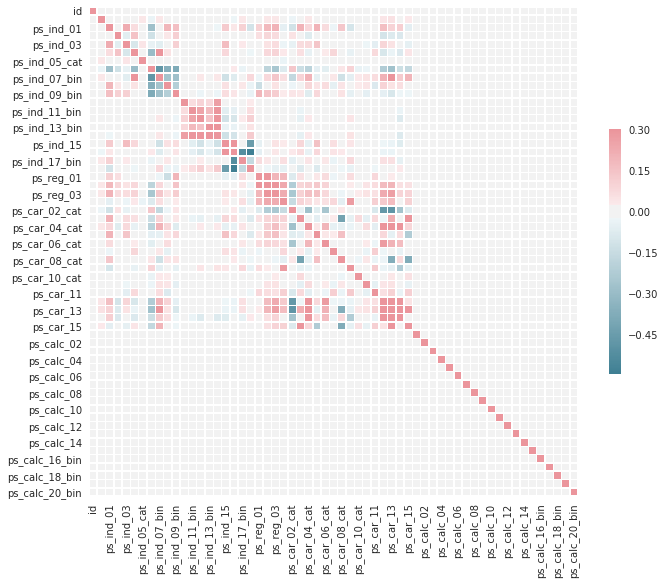

In [12]:
sns.set(style="white")


# Compute the correlation matrix
corr = train.corr()


# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

Checking percent of null values

In [13]:
for i,k in train.isnull().sum().iteritems():
    print (i,k/train.shape[0]*100)

id 0.0
target 0.0
ps_ind_01 0.0
ps_ind_02_cat 0.0362895909357
ps_ind_03 0.0
ps_ind_04_cat 0.0139446113318
ps_ind_05_cat 0.975954785858
ps_ind_06_bin 0.0
ps_ind_07_bin 0.0
ps_ind_08_bin 0.0
ps_ind_09_bin 0.0
ps_ind_10_bin 0.0
ps_ind_11_bin 0.0
ps_ind_12_bin 0.0
ps_ind_13_bin 0.0
ps_ind_14 0.0
ps_ind_15 0.0
ps_ind_16_bin 0.0
ps_ind_17_bin 0.0
ps_ind_18_bin 0.0
ps_reg_01 0.0
ps_reg_02 0.0
ps_reg_03 18.1064897885
ps_car_01_cat 0.0179767881024
ps_car_02_cat 0.000840036827215
ps_car_03_cat 69.0898368984
ps_car_04_cat 0.0
ps_car_05_cat 44.7825312662
ps_car_06_cat 0.0
ps_car_07_cat 1.93023662157
ps_car_08_cat 0.0
ps_car_09_cat 0.095596190937
ps_car_10_cat 0.0
ps_car_11_cat 0.0
ps_car_11 0.000840036827215
ps_car_12 0.000168007365443
ps_car_13 0.0
ps_car_14 7.16047391518
ps_car_15 0.0
ps_calc_01 0.0
ps_calc_02 0.0
ps_calc_03 0.0
ps_calc_04 0.0
ps_calc_05 0.0
ps_calc_06 0.0
ps_calc_07 0.0
ps_calc_08 0.0
ps_calc_09 0.0
ps_calc_10 0.0
ps_calc_11 0.0
ps_calc_12 0.0
ps_calc_13 0.0
ps_calc_14 0.0
ps_c

In [14]:
for i,k in test.isnull().sum().iteritems():
    print (i,k/test.shape[0]*100)

id 0.0
ps_ind_01 0.0
ps_ind_02_cat 0.0343855844877
ps_ind_03 0.0
ps_ind_04_cat 0.0162407483737
ps_ind_05_cat 0.975564954033
ps_ind_06_bin 0.0
ps_ind_07_bin 0.0
ps_ind_08_bin 0.0
ps_ind_09_bin 0.0
ps_ind_10_bin 0.0
ps_ind_11_bin 0.0
ps_ind_12_bin 0.0
ps_ind_13_bin 0.0
ps_ind_14 0.0
ps_ind_15 0.0
ps_ind_16_bin 0.0
ps_ind_17_bin 0.0
ps_ind_18_bin 0.0
ps_reg_01 0.0
ps_reg_02 0.0
ps_reg_03 18.1094424831
ps_car_01_cat 0.0179208257917
ps_car_02_cat 0.000560025805989
ps_car_03_cat 69.0972159997
ps_car_04_cat 0.0
ps_car_05_cat 44.842274332
ps_car_06_cat 0.0
ps_car_07_cat 1.94116144872
ps_car_08_cat 0.0
ps_car_09_cat 0.0982285263705
ps_car_10_cat 0.0
ps_car_11_cat 0.0
ps_car_11 0.000112005161198
ps_car_12 0.0
ps_car_13 0.0
ps_car_14 7.14648931023
ps_car_15 0.0
ps_calc_01 0.0
ps_calc_02 0.0
ps_calc_03 0.0
ps_calc_04 0.0
ps_calc_05 0.0
ps_calc_06 0.0
ps_calc_07 0.0
ps_calc_08 0.0
ps_calc_09 0.0
ps_calc_10 0.0
ps_calc_11 0.0
ps_calc_12 0.0
ps_calc_13 0.0
ps_calc_14 0.0
ps_calc_15_bin 0.0
ps_calc_16

All ps_calc*  variables are not related to others at all. We will remove them completely to have a better prediction.

In [15]:
unwanted = train.columns[train.columns.str.startswith('ps_calc_')]

In [16]:
train = train.drop(unwanted, axis=1)  
test = test.drop(unwanted, axis=1) 

In [17]:
train.isnull().sum()

id                    0
target                0
ps_ind_01             0
ps_ind_02_cat       216
ps_ind_03             0
ps_ind_04_cat        83
ps_ind_05_cat      5809
ps_ind_06_bin         0
ps_ind_07_bin         0
ps_ind_08_bin         0
ps_ind_09_bin         0
ps_ind_10_bin         0
ps_ind_11_bin         0
ps_ind_12_bin         0
ps_ind_13_bin         0
ps_ind_14             0
ps_ind_15             0
ps_ind_16_bin         0
ps_ind_17_bin         0
ps_ind_18_bin         0
ps_reg_01             0
ps_reg_02             0
ps_reg_03        107772
ps_car_01_cat       107
ps_car_02_cat         5
ps_car_03_cat    411231
ps_car_04_cat         0
ps_car_05_cat    266551
ps_car_06_cat         0
ps_car_07_cat     11489
ps_car_08_cat         0
ps_car_09_cat       569
ps_car_10_cat         0
ps_car_11_cat         0
ps_car_11             5
ps_car_12             1
ps_car_13             0
ps_car_14         42620
ps_car_15             0
dtype: int64

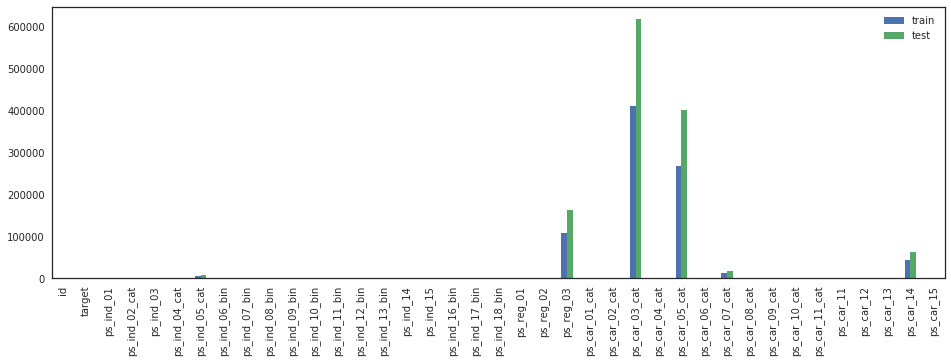

In [18]:
q= pd.DataFrame()
q['train']= train.isnull().sum()
q['test'] = test.isnull().sum()
fig,ax = plt.subplots(figsize=(16,5))
q.plot(kind='bar',ax=ax)

In [19]:
def basic_details(df):
    b = pd.DataFrame()
    #b['Missing value'] = df.isnull().sum()
    b['N unique value'] = df.nunique()
    b['dtype'] = df.dtypes
    return b
basic_details(train)

,N unique value,dtype
id,595212,int64
target,2,int64
ps_ind_01,8,int64
ps_ind_02_cat,4,float64
ps_ind_03,12,int64
ps_ind_04_cat,2,float64
ps_ind_05_cat,7,float64
ps_ind_06_bin,2,int64
ps_ind_07_bin,2,int64
ps_ind_08_bin,2,int64


In [ ]:
'''# Define the gini metric - from https://www.kaggle.com/c/ClaimPredictionChallenge/discussion/703#5897
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

def gini_xgb(preds, dtrain):
    labels = dtrain.get_label()
    gini_score = gini_normalized(labels, preds)
    return 'gini', gini_score
'''

In [ ]:
'''# More parameters has to be tuned. Good luck :)
params = {
    'min_child_weight': 7.0,
    'objective': 'binary:logistic',
    'max_depth': 4,
    'max_delta_step': 2,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'eta': 0.02,
    'gamma': 0.0,
    'num_boost_round' : 700
    }'''

In [20]:
def missing_value(df):
    col = df.columns
    for i in col:
        if df[i].isnull().sum()>0:
            df[i].fillna(df[i].mode()[0],inplace=True)

In [21]:
missing_value(train)
missing_value(test)

In [22]:
cat_col = [col for col in train.columns if '_cat' in col]
print(cat_col)

['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat', 'ps_car_02_cat', 'ps_car_03_cat', 'ps_car_04_cat', 'ps_car_05_cat', 'ps_car_06_cat', 'ps_car_07_cat', 'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat']


In [23]:
for c in cat_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [24]:
bin_col = [col for col in train.columns if 'bin' in col]
print(bin_col)

['ps_ind_06_bin', 'ps_ind_07_bin', 'ps_ind_08_bin', 'ps_ind_09_bin', 'ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_ind_16_bin', 'ps_ind_17_bin', 'ps_ind_18_bin']


In [25]:
for c in bin_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [26]:
def category_col(df):
    c_col = df.columns
    to_cat_col =[]
    for i in c_col:
        if df[i].nunique()<=104:
            to_cat_col.append(i)
    return to_cat_col


tot_cat_col = category_col(train)
other_cat_col = [c for c in tot_cat_col if c not in cat_col+ bin_col]
other_cat_col

['target',
 'ps_ind_01',
 'ps_ind_03',
 'ps_ind_14',
 'ps_ind_15',
 'ps_reg_01',
 'ps_reg_02',
 'ps_car_11',
 'ps_car_15']

In [27]:
ot_col = ['ps_ind_01','ps_ind_03','ps_ind_14','ps_ind_15','ps_car_11']
for c in ot_col:
    train[c] = train[c].astype('uint8')
    test[c] = test[c].astype('uint8') 

In [28]:
num_col = [c for c in train.columns if c not in tot_cat_col]
num_col.remove('id')
num_col

['ps_reg_03', 'ps_car_12', 'ps_car_13', 'ps_car_14']

In [29]:
train['ps_reg_03'].describe()

count    595212.000000
mean          0.846950
std           0.328237
min           0.061237
25%           0.633936
50%           0.720677
75%           1.000000
max           4.037945
Name: ps_reg_03, dtype: float64

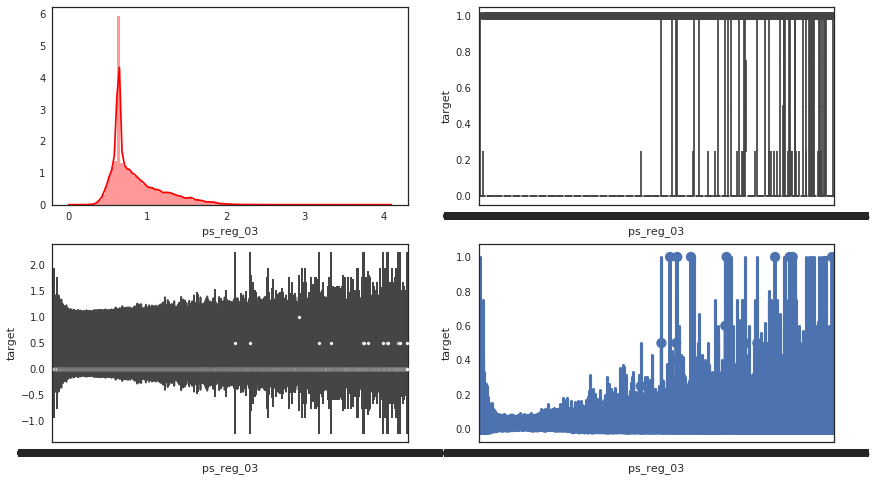

In [30]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_reg_03'],bins=100,color='red',ax=ax1)
sns.boxplot(x ='ps_reg_03',y='target',data=train,ax=ax2)
sns.violinplot(x ='ps_reg_03',y='target',data=train,ax=ax3)
sns.pointplot(x= 'ps_reg_03',y='target',data=train,ax=ax4)

In [31]:
train['ps_car_12'].describe()

count    595212.000000
mean          0.379947
std           0.058300
min           0.100000
25%           0.316228
50%           0.374166
75%           0.400000
max           1.264911
Name: ps_car_12, dtype: float64

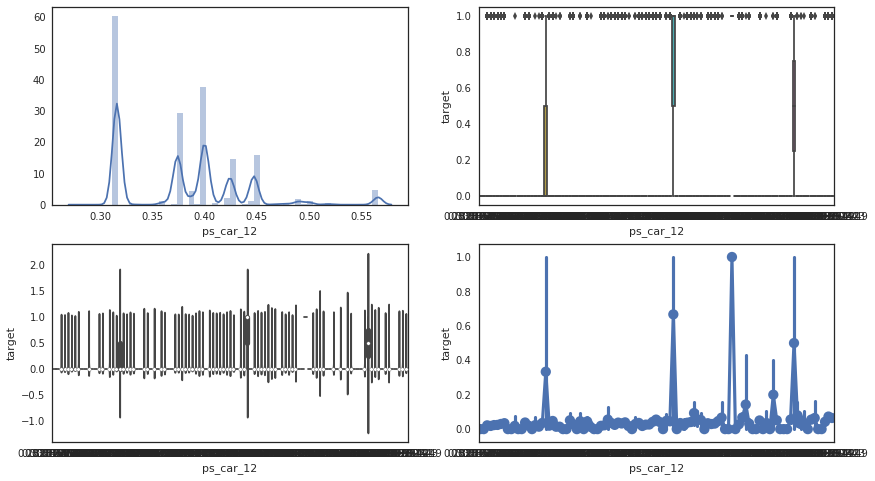

In [58]:
fig,ax = plt.subplots(2,2,figsize=(14,8))
ax1,ax2,ax3,ax4 = ax.flatten()
sns.distplot(train['ps_car_12'],bins=50,ax=ax1)
sns.boxplot(x='ps_car_12',y='target',data=train,ax=ax2)
sns.violinplot(x='ps_car_12',y='target',data=train,ax=ax3)
sns.pointplot(x='ps_car_12',y='target',data=train,ax=ax4)

In [32]:
train['ps_car_13'].describe()

count    595212.000000
mean          0.813265
std           0.224588
min           0.250619
25%           0.670867
50%           0.765811
75%           0.906190
max           3.720626
Name: ps_car_13, dtype: float64

In [33]:
train['ps_car_14'].describe()

count    595212.000000
mean          0.373748
std           0.044078
min           0.109545
25%           0.353553
50%           0.368782
75%           0.396485
max           0.636396
Name: ps_car_14, dtype: float64

In [34]:
def outlier(df,columns):
    for i in columns:
        quartile_1,quartile_3 = np.percentile(df[i],[25,75])
        quartile_f,quartile_l = np.percentile(df[i],[1,99])
        IQR = quartile_3-quartile_1
        lower_bound = quartile_1 - (1.5*IQR)
        upper_bound = quartile_3 + (1.5*IQR)
        print(i,lower_bound,upper_bound,quartile_f,quartile_l)
        df[i].loc[df[i] < lower_bound] = quartile_f
        df[i].loc[df[i] > upper_bound] = quartile_l
        
outlier(train,num_col)
outlier(test,num_col) 

ps_reg_03 0.08484029175 1.54909582495 0.4183300133 1.8521946442


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


ps_car_12 0.190569415 0.525658351 0.3155946768 0.5656854249
ps_car_13 0.31788087655 1.25917611615 0.448300509774 1.61761689551
ps_car_14 0.2891566485 0.4608812941 0.2887905816 0.5234500931
ps_reg_03 0.08156262285 1.55455860645 0.4190763654 1.8521946442
ps_car_12 0.190569415 0.525658351 0.3155946768 0.5656854249
ps_car_13 0.318887063862 1.25847823656 0.4485283558 1.61723992314
ps_car_14 0.2891566485 0.4608812941 0.2887905816 0.5234500931


In [35]:
X = train.drop(['target','id'],axis=1)
y = train['target'].astype('category')
x_test = test.drop('id',axis=1)

In [40]:
xg_cl = xgb.XGBClassifier(max_depth=4,learning_rate=0.1,n_estimators=500,objective='binary:logistic',
                          min_child_weight=1,scale_pos_weight=1)
param = {#'max_depth':[4,7,8],
         #'learning_rate':[0.01,0.03,0.1,0.3],
         #'min_child_weight':[5,6,7],
         #'reg_lambda':[0.1,0.5,1,1.3,1.7,2.5],
         #'reg_alpha':[1,1.5,3,8,10,12,15],
         #'gamma':[0,0.1,0.5,1,5,10],
         #'scale_pos_weight':[0.5,1,2,3,5,10],
        #'subsample':[0.7,0.8,0.9],
        #'colsample_bytree':[0.7,0.8,0.9]
        }
clf = GridSearchCV(xg_cl,param,scoring='roc_auc',refit=True)

clf.fit(X,y)
print('Best roc_auc: {:.4}, with best params: {}'.format(clf.best_score_, clf.best_params_)) 

Best roc_auc: 0.6362, with best params: {'max_depth': 4}


In [41]:
def runXGB(xtrain,xvalid,ytrain,yvalid,xtest,eta=0.1,num_rounds=100,max_depth=4):
    params = {
        'objective':'binary:logistic',        
        'max_depth':max_depth,
        'learning_rate':eta,
        'eval_metric':'auc',
        'min_child_weight':6,
        'subsample':0.8,
        'colsample_bytree':0.8,
        'seed':45,
        'reg_lambda':1.3,
        'reg_alpha':8,
        'gamma':10,
        'scale_pos_weight':1.6
        #'n_thread':-1
    }
    
    dtrain = xgb.DMatrix(xtrain,label=ytrain)
    dvalid = xgb.DMatrix(xvalid,label=yvalid)
    dtest = xgb.DMatrix(xtest)
    watchlist = [(dtrain,'train'),(dvalid,'test')]
    
    model = xgb.train(params,dtrain,num_rounds,watchlist,early_stopping_rounds=50,verbose_eval=50)
    pred = model.predict(dvalid,ntree_limit=model.best_ntree_limit)
    pred_test = model.predict(dtest,ntree_limit=model.best_ntree_limit)
    return pred_test,model

In [42]:
cv=2

In [43]:
kf = StratifiedKFold(n_splits=cv,random_state=45)
pred_test_full =0
cv_score = []
i=1
for train_index,test_index in kf.split(X,y):
    print('{} of KFold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    pred_test,xg_model = runXGB(xtr,xvl,ytr,yvl,x_test,num_rounds=100,eta=0.1)    
    pred_test_full += pred_test
    cv_score.append(xg_model.best_score)
    i+=1

1 of KFold 2
[0]	train-auc:0.5737	test-auc:0.572305
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.643747	test-auc:0.631154
[99]	train-auc:0.654432	test-auc:0.637464
2 of KFold 2
[0]	train-auc:0.569351	test-auc:0.568113
Multiple eval metrics have been passed: 'test-auc' will be used for early stopping.

Will train until test-auc hasn't improved in 50 rounds.
[50]	train-auc:0.645894	test-auc:0.630688
[99]	train-auc:0.657417	test-auc:0.636081


In [44]:
print(cv_score)
print('Mean cv_score',np.mean(cv_score))

[0.637464, 0.636133]
Mean cv_score 0.6367985


In [48]:
pred_xgb = pred_test_full/cv

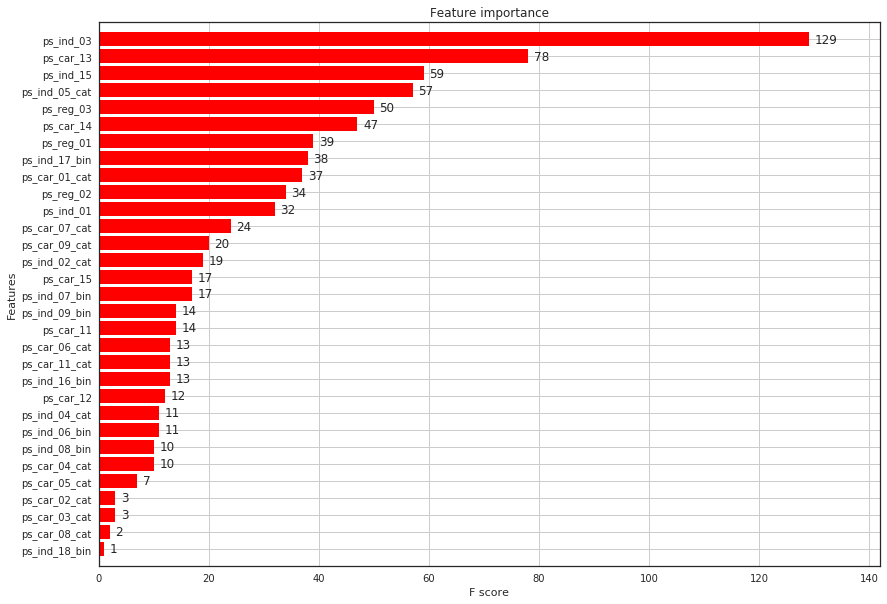

In [49]:
fig,ax = plt.subplots(figsize=(14,10))
xgb.plot_importance(xg_model,ax=ax,height=0.8,color='r')
plt.show()

In [50]:
y_pred = pred_xgb
submit = pd.DataFrame({'id':test['id'],'target':y_pred})
submit.to_csv('result.csv',index=False)

In [52]:
logreg = LogisticRegression(class_weight='balanced')
param = {'C':[0.001,0.003,0.005,0.01,0.03,0.05,0.1,0.3,0.5,1]}
clf = GridSearchCV(logreg,param,scoring='roc_auc',refit=True,cv=3)
clf.fit(X,y)
print('Best roc_auc: {:.4}, with best C: {}'.format(clf.best_score_, clf.best_params_['C'])) 

Best roc_auc: 0.6207, with best C: 0.1


In [54]:
kf = StratifiedKFold(n_splits=cv,random_state=45,shuffle=True)
pred_test_full=0
cv_score=[]
i=1
for train_index,test_index in kf.split(X,y):    
    print('\n{} of kfold {}'.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    
    lr = LogisticRegression(class_weight='balanced',C=0.1)
    lr.fit(xtr, ytr)
    pred_test = lr.predict_proba(xvl)[:,1]
    score = roc_auc_score(yvl,pred_test)
    print('roc_auc_score',score)
    cv_score.append(score)
    pred_test_full += lr.predict_proba(x_test)[:,1]
    i+=1


1 of kfold 2
roc_auc_score 0.621413381853

2 of kfold 2
roc_auc_score 0.620207228081


In [55]:
print('Confusion matrix\n',confusion_matrix(yvl,lr.predict(xvl)))
print('Cv',cv_score,'\nMean cv Score',np.mean(cv_score))

Confusion matrix
 [[179931 106828]
 [  4974   5873]]
Cv [0.62141338185309292, 0.62020722808134388] 
Mean cv Score 0.620810304967


Text(0.5,0,'False positive rate')

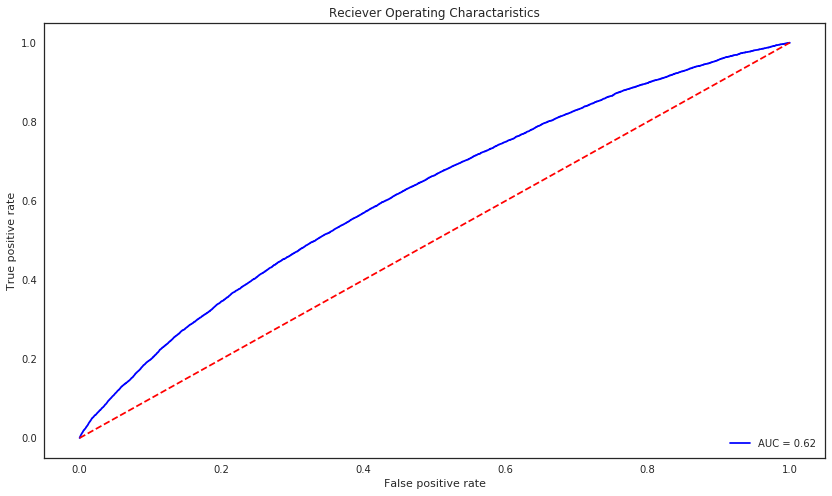

In [56]:
proba = lr.predict_proba(xvl)[:,1]
fpr,tpr, threshold = roc_curve(yvl,proba)
auc_val = auc(fpr,tpr)

plt.figure(figsize=(14,8))
plt.title('Reciever Operating Charactaristics')
plt.plot(fpr,tpr,'b',label = 'AUC = %0.2f' % auc_val)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')

In [57]:
y_pred = pred_test_full/cv